Libraries

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Config

In [3]:
DATASET_PATH = r'C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5\dataset\ACME-HappinessSurvey2020.csv'

# Where to save and retrive train & test data
TRAIN_DATASET_PATH = r"C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5\dataset\train.csv"
TEST_DATASET_PATH = r"C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5\dataset\test.csv"

# input_cols =["X1", "X2", "X3", "X4", "X5", "X6"]
# target_col = "Y"

# Threshold for logistic regression
pval_threshold = 0.15
lr_coefficient_threshold = 0.4
rf_importance_threshold = 0.13
xgb_importance_threshold = 0.16

# Where to save models and results
save_model_dir = r'C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5\models'
save_results_dir = r'C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5\results'

Dataset

In [4]:
dataset = pd.read_csv(DATASET_PATH)
df = dataset.copy()
df['X5*X6'] = (df['X5'] * df['X6']).astype(int)

X = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X5*X6']]  
y = df['Y']

**EDA**

In [6]:
# Check for missing values
print('Null Values in dataset')
print(df.isnull().sum())
print('\n')

# Check the value ranges
print(df.describe())
print('\n')

# Check if dataset is balanced
print('Y value Count')
print(df['Y'].value_counts(normalize=True))
print('\n')

Null Values in dataset
Y        0
X1       0
X2       0
X3       0
X4       0
X5       0
X6       0
X5*X6    0
dtype: int64


                Y          X1          X2          X3          X4          X5  \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     0.547619    4.333333    2.531746    3.309524    3.746032    3.650794   
std      0.499714    0.800000    1.114892    1.023440    0.875776    1.147641   
min      0.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      0.000000    4.000000    2.000000    3.000000    3.000000    3.000000   
50%      1.000000    5.000000    3.000000    3.000000    4.000000    4.000000   
75%      1.000000    5.000000    3.000000    4.000000    4.000000    4.000000   
max      1.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

               X6       X5*X6  
count  126.000000  126.000000  
mean     4.253968   15.825397  
std      0.809311    6.287867  
min      1.00000

Univariate Analysis

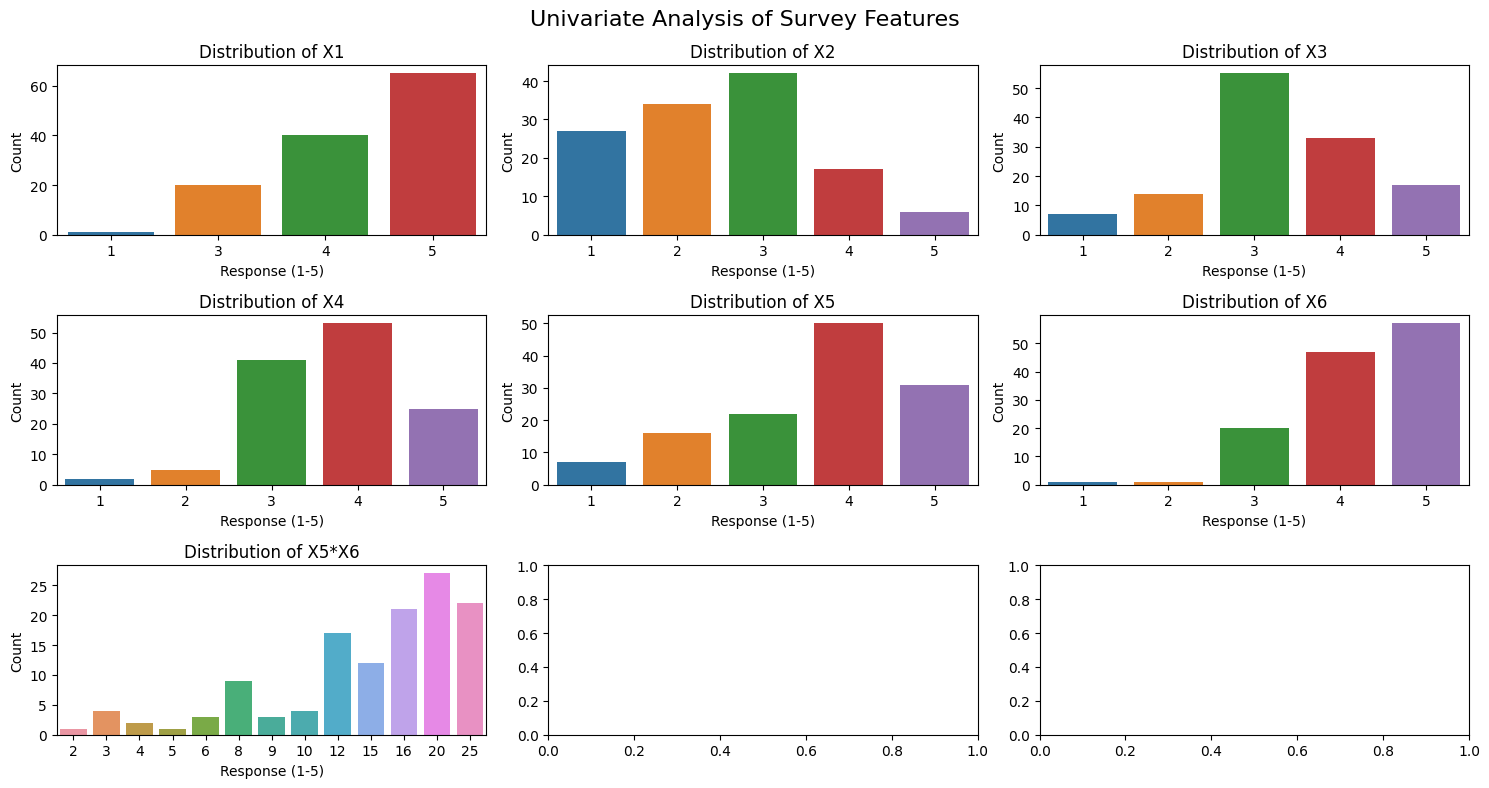

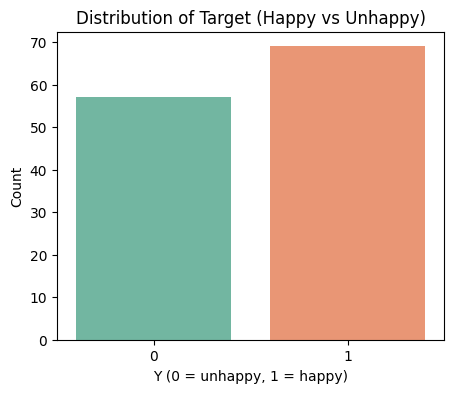

In [9]:
fig, axes = plt.subplots(3,3, figsize = (15,8))
axes = axes.flatten()

for i,col in enumerate(X.columns):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("Response (1-5)")
    axes[i].set_ylabel("Count")
plt.suptitle("Univariate Analysis of Survey Features", fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
sns.countplot(data=df, x='Y', palette="Set2")
plt.title("Distribution of Target (Happy vs Unhappy)")
plt.xlabel("Y (0 = unhappy, 1 = happy)")
plt.ylabel("Count")
plt.show()

Bivariate Analysis

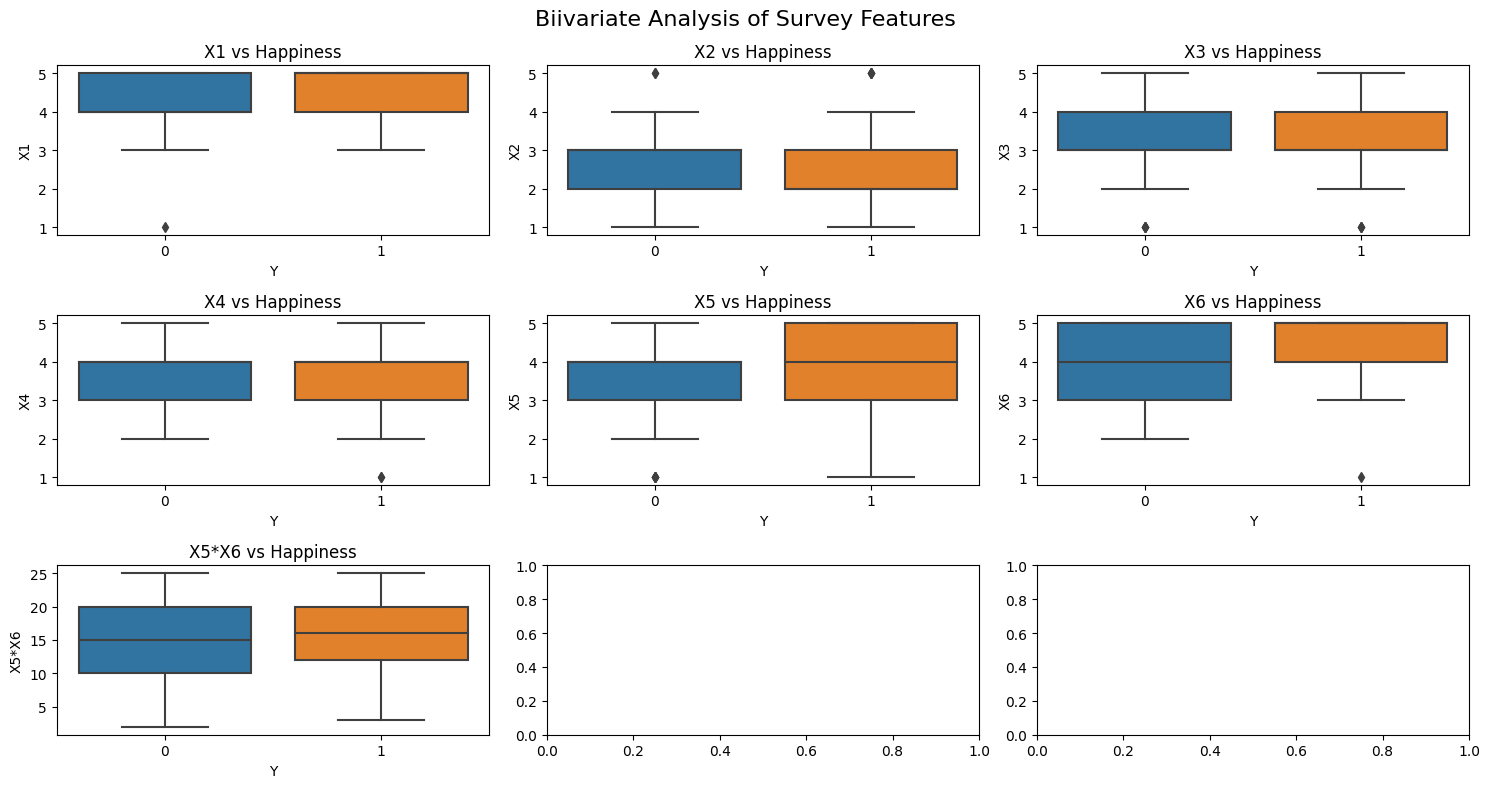

In [10]:
fig, axes = plt.subplots(3,3, figsize = (15,8))
axes = axes.flatten()

for i,col in enumerate(X.columns):
    sns.boxplot(data=df, x='Y', y=col, ax=axes[i])
    axes[i].set_title(f"{col} vs Happiness")

plt.suptitle("Biivariate Analysis of Survey Features", fontsize=16)
plt.tight_layout()
plt.show(block=False)

Mean Responses By Target

In [11]:
print('Mean Responses by Target')
print(df.groupby('Y')[['X1','X2','X3','X4','X5','X6', 'X5*X6']].mean())

Mean Responses by Target
         X1        X2        X3        X4        X5        X6      X5*X6
Y                                                                       
0  4.087719  2.561404  3.140351  3.684211  3.368421  4.105263  14.175439
1  4.536232  2.507246  3.449275  3.797101  3.884058  4.376812  17.188406


Correlation Matrix

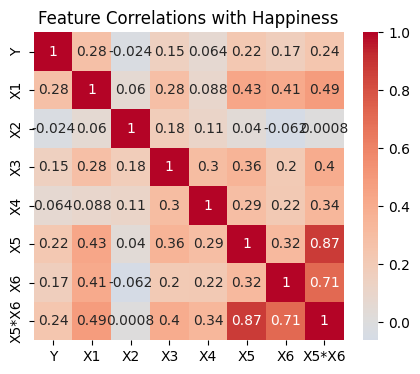

In [12]:
corr = df.corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlations with Happiness")
plt.show()

Multivariate Analysis

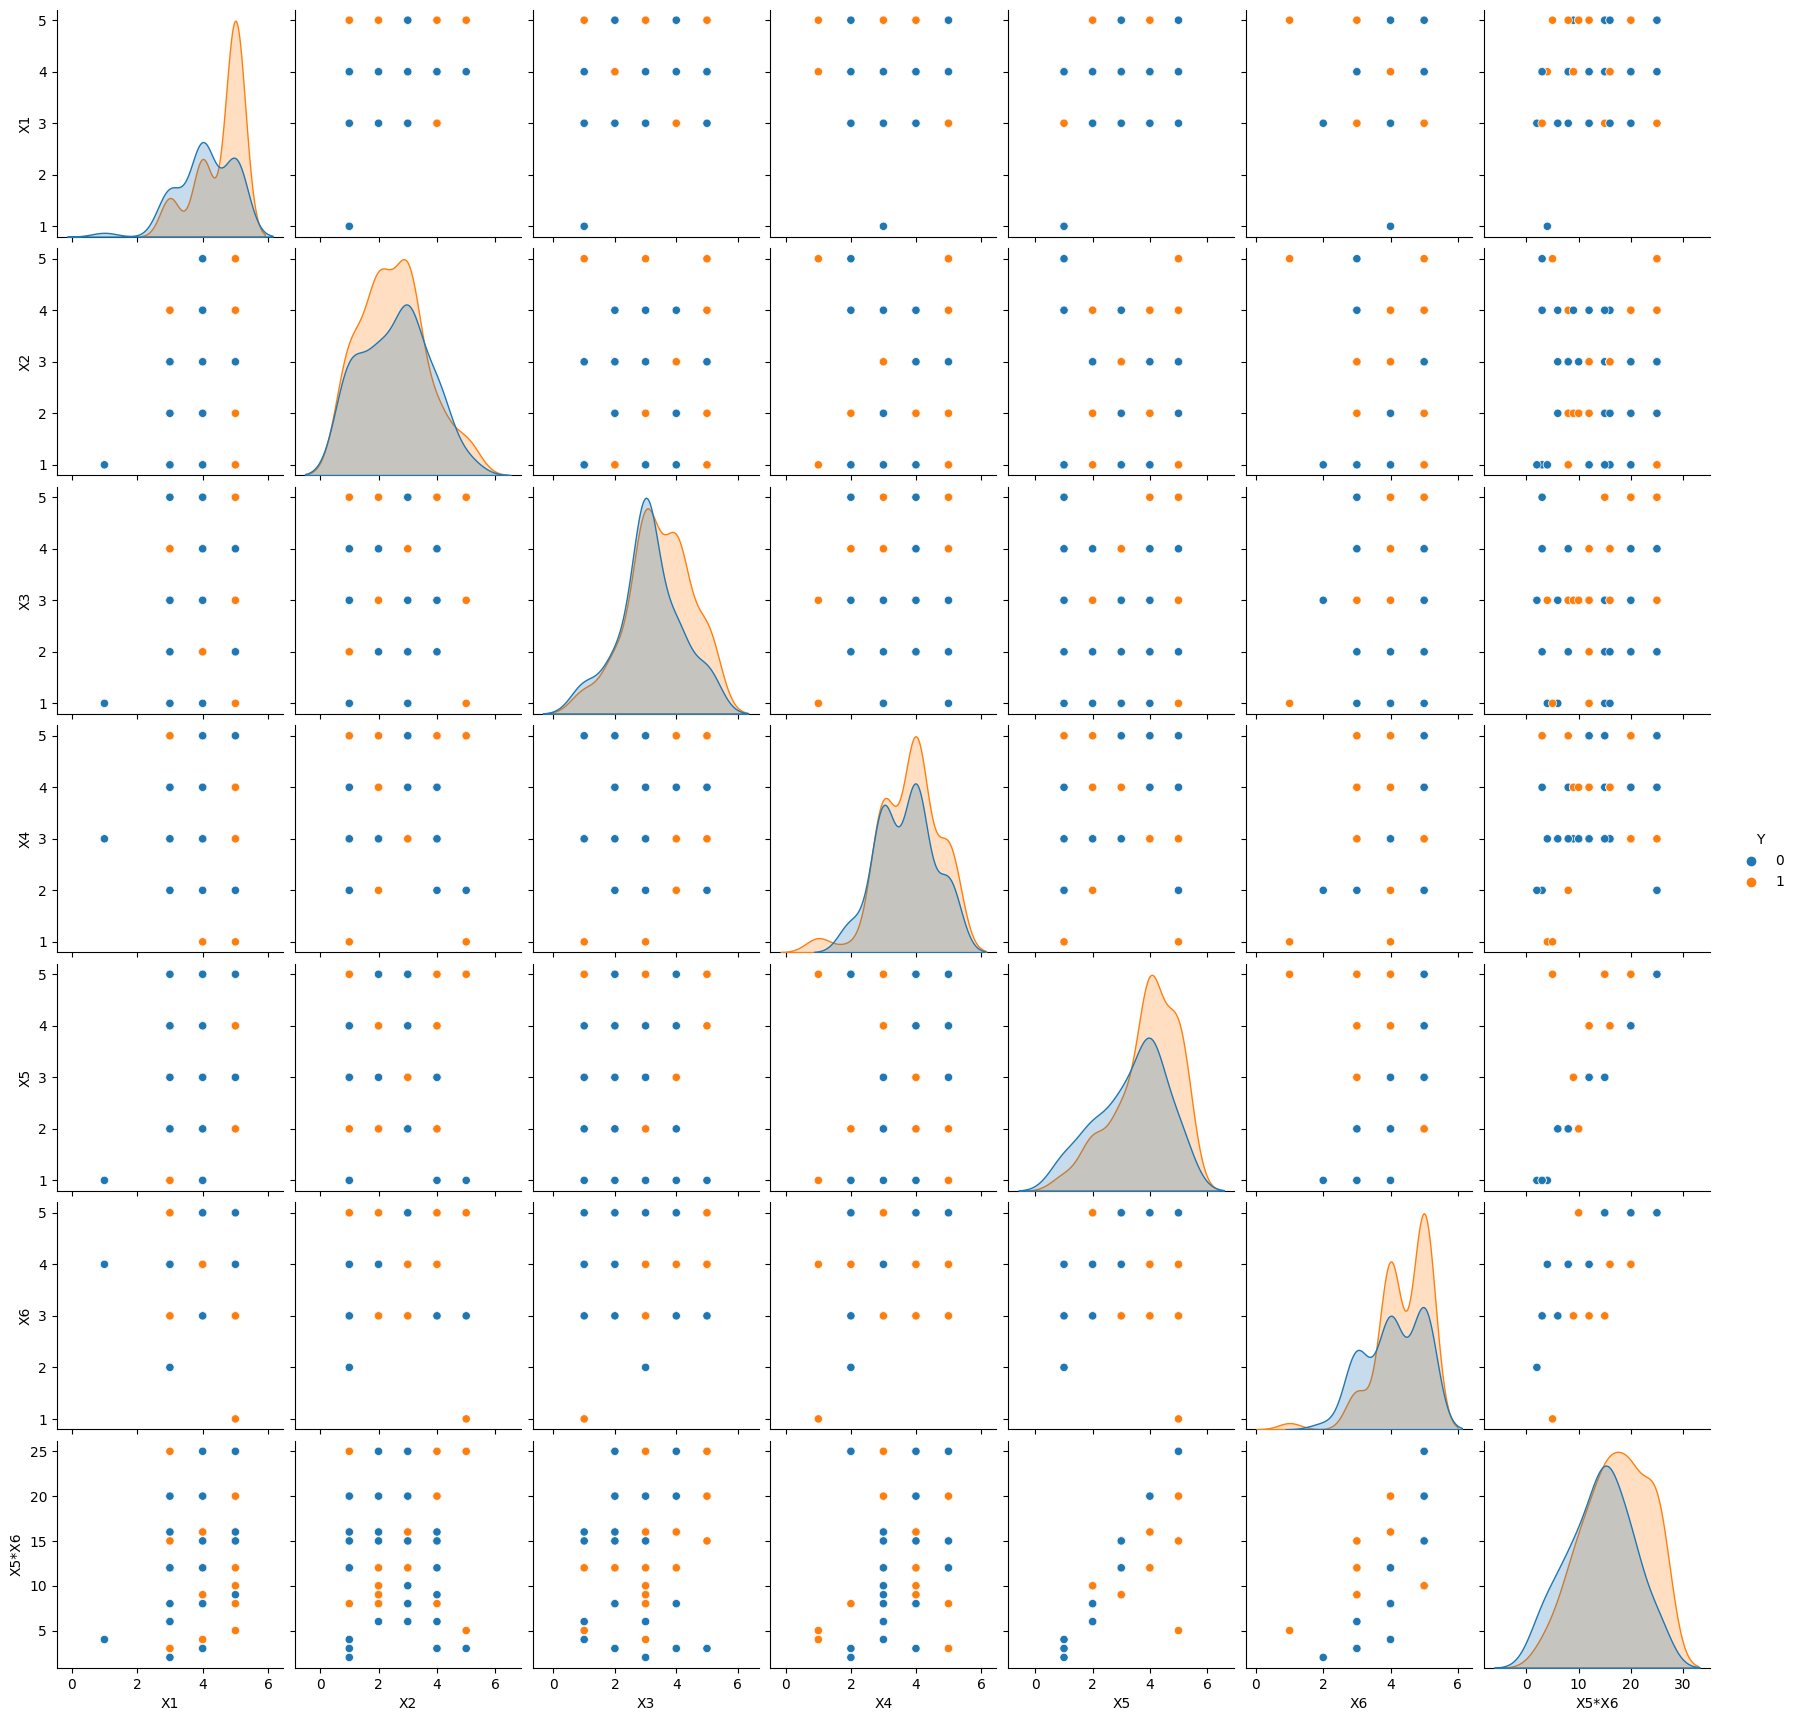

In [13]:
sns.pairplot(df, hue='Y')
plt.show()

Logistic Regression Model

In [15]:
class LogisticRegressionModel():
    def __init__(self, *args, **kwargs):
        self.scaler = StandardScaler()
        self.model = LogisticRegression(**kwargs)
        self.is_trained = False
        self.columns = None
    
    def train(self, X_train, y_train):
        self.columns = X_train.columns.tolist()
        X_train_scaled = pd.DataFrame(self.scaler.fit_transform(X_train), columns=self.columns)
        self.model.fit(X_train_scaled, y_train)
        self.is_trained = True
        print('Training Complete')
    
    def save_model(self, save_model_dir=save_model_dir):
        path = os.path.join(save_model_dir, 'logistic_regression.pkl')
        joblib.dump({"scaler": self.scaler, "columns": self.columns, "model": self.model}, path)
        print('Model Saved at: ', path)
    
    def test(self, X_test, y_test, save_results):
        if self.is_trained == False:
            raise RuntimeError("Model must be trained before testing.")
        else:
            X_test_scaled = pd.DataFrame(self.scaler.transform(X_test[self.columns]), columns=self.columns)
            accuracy = self.model.score(X_test_scaled, y_test)
            print("Accuracy on Test Set without Feature Selection:", accuracy)
            
            if save_results == True:
                y_pred = self.model.predict(X_test_scaled)
                results_df = X_test.copy()
                results_df['y_true'] = y_test
                results_df['y_pred'] = y_pred
                results_df.to_csv(os.path.join(save_results_dir, 'test_with_feature_selection.csv'), index=False)
            return accuracy
    def saved_model_test(self, X_test, y_test, model_path, save_results = True):
        saved_objects = joblib.load(model_path)
        saved_scaler, saved_columns, saved_model = saved_objects['scaler'], saved_objects["columns"], saved_objects['model']
        X_test_scaled = pd.DataFrame(saved_scaler.transform(X_test[saved_columns]), columns=saved_columns)
        accuracy = saved_model.score(X_test_scaled, y_test)
        print("Accuracy on Test Set without Feature Selection:", accuracy)
        
        # Save predictions
        if save_results == True:
            y_pred = saved_model.predict(X_test_scaled)
            results_df = X_test.copy()
            results_df['y_true'] = y_test
            results_df['y_pred'] = y_pred
            results_df.to_csv(os.path.join(save_results_dir, 'test_without_feature_selection.csv'), index=False)
        
        return accuracy

Logistic Regression with Feature Selection Model 

In [16]:
class LogisticRegressionFeatureSelectionModel():
    def __init__(self, *args, **kwargs):
        self.scaler = StandardScaler()
        self.model = LogisticRegression(**kwargs)
        self.is_trained = False
        self.columns = None
        self.features = None
    
    def get_coefficients_pvalues(self, X_train, y_train):
        self.columns = X_train.columns.tolist()
        X_train_scaled = pd.DataFrame(self.scaler.fit_transform(X_train), columns=self.columns)
        X_train_sm = sm.add_constant(X_train_scaled)
        logit_model = sm.Logit(y_train, X_train_sm)
        result = logit_model.fit()
        # result = logit_model.fit_regularized(method='l1', alpha=0.1)
        pvalues = result.pvalues.drop('const')
        return result.params, pvalues
    
    def feature_selection(self, X_train, y_train):
        coefficients, pvalues = self.get_coefficients_pvalues(X_train, y_train)
        self.features = coefficients[abs(coefficients)>lr_coefficient_threshold].index.tolist()
        print('Features Selected are: ', self.features)
        return pvalues, coefficients
    
    def train(self, X_train, y_train):
        pvalues, coefficients = self.feature_selection(X_train, y_train)
        X_train_scaled = pd.DataFrame(self.scaler.fit_transform(X_train[self.features]), columns=self.features)
        self.model.fit(X_train_scaled, y_train)
        self.is_trained = True
        print('Training Complete')
    
    def save_model(self, save_model_dir=save_model_dir):
        path = os.path.join(save_model_dir, 'logistic_regression_feature_selection.pkl')
        joblib.dump({"scaler": self.scaler, "columns": self.features, "model": self.model}, path)
        print('Model Saved at: ', path)
    
    def test(self, X_test, y_test, save_results = True):
        if self.is_trained == False:
            raise RuntimeError("Model must be trained before testing.")
        else:
            X_test_scaled = pd.DataFrame(self.scaler.transform(X_test[self.features]), columns=self.features)
            accuracy = self.model.score(X_test_scaled, y_test)
            print("Accuracy on Test Set with Feature Selection:", accuracy)
            
            if save_results == True:
                y_pred = self.model.predict(X_test_scaled)
                results_df = X_test.copy()
                results_df['y_true'] = y_test
                results_df['y_pred'] = y_pred
                results_df.to_csv(os.path.join(save_results_dir, 'test_with_feature_selection.csv'), index=False)
            return accuracy
    
    def saved_model_test(self, X_test, y_test, model_path, save_results = True):
        saved_objects = joblib.load(model_path)
        saved_scaler, saved_columns, saved_model = saved_objects['scaler'], saved_objects["columns"], saved_objects['model']
        X_test_scaled = pd.DataFrame(saved_scaler.transform(X_test[saved_columns]), columns=saved_columns)
        accuracy = saved_model.score(X_test_scaled, y_test)
        print('Features selected are: ', saved_columns)
        print("Accuracy on Test Set with Feature Selection:", accuracy)
        
        # Save predictions
        if save_results == True:
            y_pred = saved_model.predict(X_test_scaled)
            results_df = X_test.copy()
            results_df['y_true'] = y_test
            results_df['y_pred'] = y_pred
            results_df.to_csv(os.path.join(save_results_dir, 'test_with_feature_selection.csv'), index=False)
        return accuracy

Stacked Model with XGBoost, Random Forest and Logistic Regression

In [17]:
class LogisticRegressionFeatureSelectionStackedModel():
    def __init__(self):
        self.base_lr = LogisticRegression(
            penalty='l2',
            C = 1.0,
            solver='lbfgs',
            max_iter=500,
            class_weight=None,
        )
        self.rf = RandomForestClassifier(
            n_estimators=1000,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features="sqrt", 
            bootstrap=True,         
            class_weight=None,
            random_state=42
        )
        self.xgb = XGBClassifier(
            # n_estimators=1000,         
            # learning_rate=0.1,       
            # max_depth=None,              
            # subsample=0.8,           
            # colsample_bytree=0.8,     
            # gamma=0,                  
            # reg_alpha=0,              
            # reg_lambda=1,             
            # scale_pos_weight=1,       
            # min_child_weight=1,      
            # random_state=42,
            # eval_metric="logloss"
        )
        self.is_trained = False
        self.stacked_model = None
        self.columns = None
        self.lr_features = None
        self.rf_features = None
        self.xgb_features = None
    
    def get_lr_coefficients_pvalues(self, X_train, y_train):
        scaler = StandardScaler()
        self.columns = X_train.columns.tolist()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=self.columns)
        X_train_sm = sm.add_constant(X_train_scaled)
        logit_model = sm.Logit(y_train, X_train_sm)
        result = logit_model.fit()
        # result = logit_model.fit_regularized(method='l1', alpha=0.1)
        pvalues = result.pvalues.drop('const')
        return result.params, pvalues      
        
    def feature_selection(self, X_train, y_train):
        coefficients, pvalues = self.get_lr_coefficients_pvalues(X_train, y_train)
        self.lr_features = coefficients[abs(coefficients)>lr_coefficient_threshold].index.tolist()
        print('LR feature Coefficients:\n ', coefficients)
        print('Features Selected for LR: ', self.lr_features)
        self.rf.fit(X_train, y_train)
        rf_importances = pd.Series(self.rf.feature_importances_, index=X_train.columns)
        self.rf_features = rf_importances[rf_importances>rf_importance_threshold].index.tolist()
        print('RF feature importances:\n ', rf_importances)
        print('Features Selected for RF: ', self.rf_features)
        self.xgb.fit(X_train, y_train)
        xgb_importances = pd.Series(self.xgb.feature_importances_, index=X_train.columns)
        self.xgb_features = xgb_importances[xgb_importances>xgb_importance_threshold].index.tolist()
        print('XGB feature importances:\n ', xgb_importances)
        print('Features Selected for XGB: ', self.xgb_features)
    
    def train(self, X_train, y_train):
        self.feature_selection(X_train, y_train)
        
        lr_pipeline = Pipeline([('select_lr_features', ColumnTransformer([('lr_features', 'passthrough', self.lr_features)], remainder='drop')), 
                                ('scaler', StandardScaler()), ('lr', self.base_lr)])
        rf_pipeline = Pipeline([('select_rf_features', ColumnTransformer([('rf_features', 'passthrough', self.rf_features)], remainder='drop')), 
                                ('rf', self.rf)])
        xgb_pipeline = Pipeline([('select_xgb_features', ColumnTransformer([('xgb_features', 'passthrough', self.xgb_features)], remainder='drop')), 
                                ('xgb', self.xgb)])
        self.stacked_model = StackingClassifier(
            estimators=[
                ('lr', lr_pipeline),
                ('rf' ,rf_pipeline),
                ('xgb' ,xgb_pipeline)
            ],
            final_estimator=LogisticRegression(),
            cv=5,
            # stack_method='predict'
        )
        
        self.stacked_model.fit(X_train, y_train)
        self.is_trained = True
        print('Training Complete')
    
    def save_model(self, save_model_dir=save_model_dir):
        path = os.path.join(save_model_dir, 'logistic_regression_stacked.pkl')
        joblib.dump({'lr_features': self.lr_features, 'rf_features': self.rf_features, 'xgb_features': self.xgb_features, "model": self.stacked_model}, path)
        print('Model Saved at: ', path)
    
    def test(self, X_test, y_test, save_results = True):
        if self.is_trained == False:
            raise RuntimeError("Model must be trained before testing.")
        else:
            accuracy = self.stacked_model.score(X_test, y_test)
            print("Accuracy on Test Set with Feature Selection:", accuracy)
            
            if save_results == True:
                y_pred = self.stacked_model.predict(X_test)
                results_df = X_test.copy()
                results_df['y_true'] = y_test
                results_df['y_pred'] = y_pred
                results_df.to_csv(os.path.join(save_results_dir, 'test_with_feature_selection.csv'), index=False)
            return accuracy
    
    def saved_model_test(self, X_test, y_test, model_path, save_results = True):
        saved_objects = joblib.load(model_path)
        saved_lr_features, saved_rf_features, saved_xgb_features, saved_model = saved_objects['lr_features'], saved_objects['rf_features'], saved_objects['xgb_features'], saved_objects['model']
        accuracy = saved_model.score(X_test, y_test)
        
        print('Features selected for LR are: ', saved_lr_features)
        print('Features selected for RF are: ', saved_rf_features)
        print('Features selected for XGB are: ', saved_xgb_features)
        print("Accuracy on Test Set with Stacked Mode;:", accuracy)
        
        lr_pred = saved_model.named_estimators_['lr'].predict(X_test)
        rf_pred = saved_model.named_estimators_['rf'].predict(X_test)
        xgb_pred = saved_model.named_estimators_['xgb'].predict(X_test)
        print("LR vs RF predictions correlation:", np.corrcoef(lr_pred, rf_pred)[0,1])
        print("RF vs XGB predictions correlation:", np.corrcoef(rf_pred, xgb_pred)[0,1])
        print("LR vs XGB predictions correlation:", np.corrcoef(lr_pred, xgb_pred)[0,1])
        print('Model Output Coefficients [LR, RF, XGB]: ', saved_model.final_estimator_.coef_)
        
        # Save predictions
        if save_results == True:
            y_pred = saved_model.predict(X_test)
            results_df = X_test.copy()
            results_df['y_true'] = y_test
            results_df['y_pred'] = y_pred
            results_df.to_csv(os.path.join(save_results_dir, 'test_with_stacked_model.csv'), index=False)
        return accuracy

Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.15,
    random_state=42,
    stratify=y
)

# Reset Indices
X_train, X_test = X_train.reset_index(drop = True), X_test.reset_index(drop = True)
y_train, y_test = y_train.reset_index(drop = True), y_test.reset_index(drop = True)

# Combine X and y for train and test sets
train_df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

# Save to CSV
train_df.to_csv(TRAIN_DATASET_PATH, index=False)
test_df.to_csv(TEST_DATASET_PATH, index=False)

Training the models

In [18]:
# Train Logistic Regression Model without feature selection
print('-----------Logistic Regression------------------')
model_without_fs = LogisticRegressionModel()
model_without_fs.train(X_train, y_train)
# Save model
model_without_fs.save_model()

# Train Logistic Regression Model with feature selection
print('-----------Logistic Regression Feature Selection------------------')
model_fs = LogisticRegressionFeatureSelectionModel()
model_fs.train(X_train, y_train)
model_fs.save_model()

# Train Logistic Regression Model with feature selection
print('-----------Logistic Regression Model Stacked Model with feature selection------------------')
model_stacked = LogisticRegressionFeatureSelectionStackedModel()
model_stacked.train(X_train, y_train)
model_stacked.save_model()

-----------Logistic Regression------------------
Training Complete
Model Saved at:  C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5\models\logistic_regression.pkl
-----------Logistic Regression Feature Selection------------------
Optimization terminated successfully.
         Current function value: 0.647131
         Iterations 5
Features Selected are:  ['X1', 'X5']
Training Complete
Model Saved at:  C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5\models\logistic_regression_feature_selection.pkl
-----------Logistic Regression Model Stacked Model with feature selection------------------
Optimization terminated successfully.
         Current function value: 0.647131
         Iterations 5
LR feature Coefficients:
  const    0.210616
X1       0.417430
X2      -0.094105
X3       0.114642
X4       0.041895
X5       0.473622
X6       0.166686
X5*X6   -0.350836
dtype: float64
Features Selected for LR:  ['X1', 'X5']
RF feature importances:
  X1       0.160589
X2       0.174966
X

Test Models

In [19]:
# Test Logistic Regression Model without feature selection
print('-----------Logistic Regression------------------')
model_without_fs = LogisticRegressionModel()
model_path = os.path.join(save_model_dir, 'logistic_regression.pkl')
model_without_fs.saved_model_test(X_test, y_test, model_path)

# Test Logistic Regression Model with feature selection
print('-----------Logistic Regression Feature Selection------------------')
model_with_fs = LogisticRegressionFeatureSelectionModel()
model_path = os.path.join(save_model_dir, 'logistic_regression_feature_selection.pkl')
model_with_fs.saved_model_test(X_test, y_test, model_path)

# Test Logistic Regression Model Stacked Model with feature selection
print('-----------Logistic Regression Model Stacked Model with feature selection------------------')
model_stacked = LogisticRegressionFeatureSelectionStackedModel()
model_path = os.path.join(save_model_dir, 'logistic_regression_stacked.pkl')
model_stacked.saved_model_test(X_test, y_test, model_path)

-----------Logistic Regression------------------
Accuracy on Test Set without Feature Selection: 0.6842105263157895
-----------Logistic Regression Feature Selection------------------
Features selected are:  ['X1', 'X5']
Accuracy on Test Set with Feature Selection: 0.6842105263157895
-----------Logistic Regression Model Stacked Model with feature selection------------------
Features selected for LR are:  ['X1', 'X5']
Features selected for RF are:  ['X1', 'X2', 'X3', 'X4', 'X5*X6']
Features selected for XGB are:  ['X1', 'X3', 'X6']
Accuracy on Test Set with Stacked Mode;: 0.8421052631578947
LR vs RF predictions correlation: 0.26772483504820255
RF vs XGB predictions correlation: -0.011631052629980862
LR vs XGB predictions correlation: 0.3692744729379981
Model Output Coefficients [LR, RF, XGB]:  [[0.52668744 0.21480243 1.47539266]]


0.8421052631578947